In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

/var/folders/_6/fpk79cm53rxgcj2gh5prtww00000gn/T/ipykernel_2825/856264201.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

mnist_data = datasets.MNIST(
    root="data/", train=True, transform=transforms.ToTensor(), download=True
)
dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [3]:
#Check the dataset
total_train = 0
for features, label in dataloader:
    total_train = total_train + features.shape[0]

print("The shape of this dataset: {} ".format(features.shape))
print("# of the dataset that I downloaded = {} ".format(total_train))

The shape of this dataset: torch.Size([32, 1, 28, 28]) 
# of the dataset that I downloaded = 60000 


In [4]:
features.reshape(-1, 28*28).shape

torch.Size([32, 784])

In [5]:
class Generator(nn.Module):
    """
    A generative neural network model for generating images using the DCGAN architecture.

    Args:
        latent_space (int): The dimensionality of the latent space noise vector. Default is 100.

    Attributes:
        latent_space (int): The dimensionality of the latent space noise vector.
        model (nn.Sequential): The generator model composed of several layers.

    Example:
        >>> generator = Generator(latent_space=100)
        >>> noise = torch.randn(64, 100)
        >>> generated_images = generator(noise)
    """

    def __init__(self, latent_space=100):
        """
        Initialize the Generator.

        Args:
            latent_space (int, optional): The dimensionality of the latent space noise vector. Default is 100.
        """
        self.latent_space = latent_space
        super(Generator, self).__init__()
        layers_config = [
            (self.latent_space, 256, 0.2),
            (256, 512, 0.2),
            (512, 1024, 0.2),
            (1024, 28 * 28),
        ]
        self.model = self.generate_layer(layers_config=layers_config)

    def generate_layer(self, layers_config):
        """
        Create the layers of the generator model based on the provided configuration.

        Args:
            layers_config (list): A list of tuples specifying the layer configurations.

        Returns:
            nn.Sequential: A sequential model containing the specified layers.

        Example:
            >>> layers_config = [(100, 256, 0.02), (256, 512, 0.02), (512, 1024, 0.02), (1024, 28*28)]
            >>> generator = Generator()
            >>> generator_model = generator.generate_layer(layers_config)
        """
        layers = OrderedDict()
        for index, (input_feature, out_feature, negative_slope) in enumerate(
            layers_config[:-1]
        ):
            layers[f"layer_{index}"] = nn.Linear(
                in_features=input_feature, out_features=out_feature
            )
            layers[f"layer_{index}_activation"] = nn.LeakyReLU(
                negative_slope=negative_slope
            )

        layers[f"output_layer"] = nn.Linear(
            in_features=layers_config[-1][0], out_features=layers_config[-1][1]
        )
        layers[f"output_layer_activation"] = nn.Tanh()

        return nn.Sequential(layers)

    def forward(self, x):
        """
        Forward pass of the generator model.

        Args:
            x (torch.Tensor): Input noise tensor sampled from the latent space.

        Returns:
            torch.Tensor: Generated images.

        Example:
            >>> noise = torch.randn(64, 100)
            >>> generated_images = generator(noise)
        """
        if x is not None:
            x = self.model(x)
        else:
            x = "ERROR"

        return x.reshape(-1, 1, 28, 28)

In [6]:
generator = Generator()

print(generator.parameters)

<bound method Module.parameters of Generator(
  (model): Sequential(
    (layer_0): Linear(in_features=100, out_features=256, bias=True)
    (layer_0_activation): LeakyReLU(negative_slope=0.2)
    (layer_1): Linear(in_features=256, out_features=512, bias=True)
    (layer_1_activation): LeakyReLU(negative_slope=0.2)
    (layer_2): Linear(in_features=512, out_features=1024, bias=True)
    (layer_2_activation): LeakyReLU(negative_slope=0.2)
    (output_layer): Linear(in_features=1024, out_features=784, bias=True)
    (output_layer_activation): Tanh()
  )
)>


In [7]:
# Total number of parameters of Generator

total_parameters = 0
for layer, params in generator.named_parameters():
    total_parameters += params.numel()
    print("Layer: {} & # of parameters: {} ".format(layer, params.numel()))


print(
    "\nTotal number of parameters of generator is {} ".format(total_parameters).upper()
)

Layer: model.layer_0.weight & # of parameters: 25600 
Layer: model.layer_0.bias & # of parameters: 256 
Layer: model.layer_1.weight & # of parameters: 131072 
Layer: model.layer_1.bias & # of parameters: 512 
Layer: model.layer_2.weight & # of parameters: 524288 
Layer: model.layer_2.bias & # of parameters: 1024 
Layer: model.output_layer.weight & # of parameters: 802816 
Layer: model.output_layer.bias & # of parameters: 784 

TOTAL NUMBER OF PARAMETERS OF GENERATOR IS 1486352 


In [8]:
class Discriminator(nn.Module):
    """
    A Discriminator class representing a neural network model for distinguishing real images from generated ones.

    This class inherits from nn.Module and constructs a neural network discriminator model suitable for a Generative
    Adversarial Network (GAN). The discriminator is designed to take flattened image inputs (such as those from the
    MNIST dataset) and output a single value indicating the likelihood that the image is real.

    Attributes:
        model (torch.nn.Sequential): A sequential container of layers forming the discriminator network. The architecture
                                     is defined based on the layers configuration provided in `layers_config`.

    Methods:
        forward(x): Defines the forward pass of the discriminator.

    Parameters:
        layers_config (list of tuples): Each tuple in the list contains configuration for a layer in the model,
                                        including the number of input features, output features, and the negative
                                        slope for the LeakyReLU activation function. The last layer uses a Sigmoid
                                        activation function instead of LeakyReLU.
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        layers_config = [
            (28 * 28, 512, 0.2),
            (512, 256, 0.2),
            (256, 1),
        ]
        self.model = self.discriminator_block(layers_config)

    def discriminator_block(self, layers_config):
        """
        Builds the discriminator block based on the provided layers configuration.

        Args:
            layers_config (list of tuples): Configuration for each layer in the discriminator model.

        Returns:
            torch.nn.Sequential: A sequential container of layers forming the discriminator network.
        """
        layers = OrderedDict()
        for index, (input_features, output_features, negative_slope) in enumerate(
            layers_config[:-1]
        ):
            layers[f"{index}_layer"] = nn.Linear(
                in_features=input_features, out_features=output_features
            )
            layers[f"{index}_activation"] = nn.LeakyReLU(negative_slope=negative_slope)

        # Output layer with Sigmoid activation
        layers["output_layer"] = nn.Linear(
            in_features=layers_config[-1][0], out_features=layers_config[-1][1]
        )
        layers["output_activation"] = nn.Sigmoid()

        return nn.Sequential(layers)

    def forward(self, x):
        """
        Defines the forward pass of the discriminator.

        Args:
            x (torch.Tensor): The input tensor containing the image data.

        Returns:
            torch.Tensor: The output of the discriminator, representing the probability that the input image is real.
        """
        if x is not None:
            x = x.view(-1, 28 * 28)
            x = self.model(x)
        else:
            x = "ERROR"
        return x

In [9]:
discriminator = Discriminator()

print(discriminator.parameters)

<bound method Module.parameters of Discriminator(
  (model): Sequential(
    (0_layer): Linear(in_features=784, out_features=512, bias=True)
    (0_activation): LeakyReLU(negative_slope=0.2)
    (1_layer): Linear(in_features=512, out_features=256, bias=True)
    (1_activation): LeakyReLU(negative_slope=0.2)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
    (output_activation): Sigmoid()
  )
)>


In [10]:
# Total number of parameters of Discriminator

total_parameters = 0
for layer, params in discriminator.named_parameters():
    total_parameters+=params.numel()
    print("Layer: {} & # of parameters: {} ".format(layer, params.numel()))
    

print("\nTotal number of parameters of discriminator is {} ".format(total_parameters).upper()) 

Layer: model.0_layer.weight & # of parameters: 401408 
Layer: model.0_layer.bias & # of parameters: 512 
Layer: model.1_layer.weight & # of parameters: 131072 
Layer: model.1_layer.bias & # of parameters: 256 
Layer: model.output_layer.weight & # of parameters: 256 
Layer: model.output_layer.bias & # of parameters: 1 

TOTAL NUMBER OF PARAMETERS OF DISCRIMINATOR IS 533505 


In [11]:
# Check the GPU in MAC
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)

print(device)

mps


In [12]:
# Connect to the GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [13]:
# Define the loss function and optimizer

loss_function = nn.BCELoss()
learning_rate = 0.0001

optimizer_generator = optim.Adam(
    generator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)
optimizer_discriminator = optim.Adam(
    discriminator.parameters(), lr=learning_rate, betas= (0.5, 0.999)
)

In [14]:
# check whether Generator and Discriminator works or not !
batch_size = 64
latent_space = 100

# Generator
noise_data = torch.randn(batch_size, latent_space)
print("Generator data using noise # ", generator(noise_data.to(device)).shape)

# Discriminator
dataset = torch.randn(batch_size, 64, 28, 28)
print("Discriminator shape # ", discriminator(dataset.to(device)).shape)

Generator data using noise #  torch.Size([64, 1, 28, 28])
Discriminator shape #  torch.Size([4096, 1])


In [15]:
# Define the discriminator training function
def train_discriminator(real_samples, fake_samples, real_labels, fake_labels):
    """
    Train the discriminator of a Generative Adversarial Network (GAN).

    This function updates the discriminator by training it on both real and fake samples.
    It calculates the loss for both real and fake predictions and backpropagates the total loss
    to update the discriminator's weights.

    Parameters:
    - real_samples (Tensor): A batch of real samples from the dataset.
    - fake_samples (Tensor): A batch of fake samples generated by the GAN's generator.
    - real_labels (Tensor): A batch of labels, typically ones, representing real samples.
    - fake_labels (Tensor): A batch of labels, typically zeros, representing fake samples.

    The function assumes that the discriminator and loss_function are globally accessible,
    and it also utilizes the optimizer_discriminator for the backpropagation process.

    Returns:
    - float: The total loss incurred by the discriminator for the current batch of real and fake samples.
    """
    optimizer_discriminator.zero_grad()

    real_predicted = discriminator(real_samples)
    fake_predicted = discriminator(fake_samples.detach())

    real_predicted_loss = loss_function(real_predicted, real_labels)
    fake_predicted_loss = loss_function(fake_predicted, fake_labels)

    total_discriminator_loss = real_predicted_loss + fake_predicted_loss

    total_discriminator_loss.backward()
    optimizer_discriminator.step()

    return total_discriminator_loss.item()


# Define the generator training function
def train_generator(fake_samples, real_labels):
    """
    Train the generator of a Generative Adversarial Network (GAN).

    This function trains the generator by attempting to fool the discriminator. It updates
    the generator based on how well it can trick the discriminator into classifying the
    generated (fake) samples as real. The function calculates the loss by comparing the
    discriminator's predictions on the fake samples against the 'real' labels and then
    performs backpropagation to update the generator's weights.

    Parameters:
    - fake_samples (Tensor): A batch of fake samples generated by the GAN's generator.
    - real_labels (Tensor): A batch of labels, typically ones, used as targets for training the generator.

    This function assumes the availability of a globally accessible discriminator model,
    a loss function, and the optimizer for the generator (optimizer_generator).

    Returns:
    - float: The loss incurred by the generator for the current batch of fake samples, indicating
             how well the generator is able to fool the discriminator.
    """
    optimizer_generator.zero_grad()

    fake_predict = discriminator(fake_samples)

    generated_loss = loss_function(fake_predict, real_labels)

    generated_loss.backward()
    optimizer_generator.step()

    return generated_loss.item()


def train_gan():
    """
    Train a Generative Adversarial Network (GAN) consisting of a generator and discriminator.

    This function orchestrates the training process of a GAN over a specified number of epochs.
    Training involves alternating between training the discriminator and the generator.
    The discriminator is trained to distinguish real data from fake data generated by the generator,
    while the generator is trained to produce data that appears real to the discriminator.

    Parameters:
    - epochs (int): The number of training epochs.
    - latent_space (int): The size of the latent space used to generate noise samples for the generator.
    - print_interval (int): Interval of steps for printing training progress within each epoch.
    - dataloader (DataLoader): DataLoader object providing access to the dataset.
    - device (torch.device): The device (CPU/GPU) on which the training is performed.

    The function assumes that 'train_discriminator' and 'train_generator' are pre-defined functions
    that handle the training of the discriminator and generator, respectively. Additionally,
    'generator' and 'discriminator' should be predefined models. The function also requires
    'np.mean' for calculating average losses, and it prints the training progress at regular intervals.

    Returns:
    None: This function does not return a value but prints the training progress and average losses per epoch.
    """

    epochs = 100
    latent_space = 100
    print_interval = 100

    for epoch in range(epochs):
        discriminator_loss = []
        generator_loss = []

        for i, (real_samples, _) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size = real_samples.shape[0]

            # Generate noise samples and fake samples
            noise_samples = torch.randn(batch_size, latent_space).to(device)
            fake_samples = generator(noise_samples)

            # Define labels for real and fake samples
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train the discriminator
            d_loss = train_discriminator(
                real_samples=real_samples,
                fake_samples=fake_samples,
                real_labels=real_labels,
                fake_labels=fake_labels,
            )

            # Train the generator
            g_loss = train_generator(fake_samples=fake_samples, real_labels=real_labels)

            discriminator_loss.append(d_loss)
            generator_loss.append(g_loss)

            # Print training progress every 'print_interval' iterations
            if i % print_interval == 0:
                print(
                    f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(dataloader)}], d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}"
                )

        # Output average loss at the end of each epoch
        print(f"Epoch [{epoch + 1}/{epochs}] Completed")
        print(
            f"[==============] Average d_loss: {np.mean(discriminator_loss):.4f} - Average g_loss: {np.mean(generator_loss):.4f}"
        )
        


train_gan()

Epoch [1/100], Step [0/938], d_loss: 1.3969, g_loss: 0.6777
Epoch [1/100], Step [100/938], d_loss: 1.3616, g_loss: 0.7243
Epoch [1/100], Step [200/938], d_loss: 1.3294, g_loss: 0.7234
Epoch [1/100], Step [300/938], d_loss: 1.2967, g_loss: 0.8190
Epoch [1/100], Step [400/938], d_loss: 1.1841, g_loss: 0.8169
Epoch [1/100], Step [500/938], d_loss: 1.4153, g_loss: 0.7578
Epoch [1/100], Step [600/938], d_loss: 1.2028, g_loss: 1.0552
Epoch [1/100], Step [700/938], d_loss: 1.2939, g_loss: 0.9768
Epoch [1/100], Step [800/938], d_loss: 1.4241, g_loss: 0.8936
Epoch [1/100], Step [900/938], d_loss: 1.1223, g_loss: 1.0500
Epoch [1/100] Completed
[==============] Average d_loss: 1.3019 - Average g_loss: 0.8511
Epoch [2/100], Step [0/938], d_loss: 1.4426, g_loss: 1.1947
Epoch [2/100], Step [100/938], d_loss: 1.2612, g_loss: 1.1199
Epoch [2/100], Step [200/938], d_loss: 1.3420, g_loss: 0.8174
Epoch [2/100], Step [300/938], d_loss: 1.2889, g_loss: 1.1074
Epoch [2/100], Step [400/938], d_loss: 1.3697, 

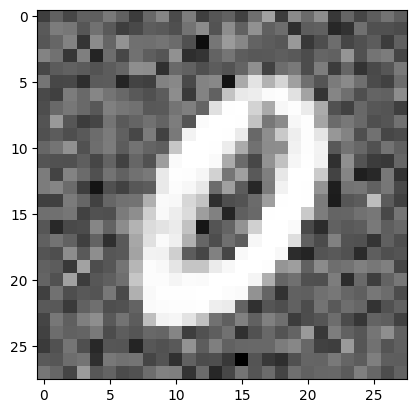

In [16]:
noise_data = torch.randn(1, 100)
generated_samples = generator(noise_data.to(device))
generated_samples = generated_samples.detach()

plt.imshow(generated_samples.detach().cpu().view(28, 28), cmap="gray")
plt.show()